In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as color
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# 1)

To make code more robust, I am re-writing the code from last unit. Changes include:
1. Including an electric field method inside the charge class

2. Including a separate function for termination criteria

3. Plotting inside the field line function

4. Generalizing so that the boundary conditions for dipoles (symmetric about x-axis) can be selected and un-selected. This allows for unbalanced charge configurations to be plotted (field lines can now terminate at the boundary)

5. Creating a separate function for the Euler method (and the RK2 method) for simpler implementation

In [2]:
class Charge:
    def __init__(self,x,y,q):
        self.x=x
        self.y=y
        self.q=q
        return
    def potential(self, xgrid, ygrid): 
        dx = xgrid - self.x
        dy = ygrid - self.y
        r = np.sqrt(dx**2 + dy**2)
        return self.q / r 
    
    def e_field(self, x, y): # Method for calculating electric field 
        dx = x - self.x
        dy = y - self.y
        r = np.sqrt(dx**2 + dy**2)

        Ex = self.q * dx / r**3
        Ey = self.q * dy / r**3
        
        return Ex, Ey

In [3]:
def mplot(charges, xlim, ylim): # Plotting function to reduce redundancy
    _, ax = plt.subplots(1,1)

    for charge in charges:
        if charge.q > 0:
            c = "red"
        else:
            c = "blue"
        plt.scatter(charge.x, charge.y, c=c)
    
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)
    ax.set_aspect('equal') # Set plot to be equal aspect 

    ax.set_xticks(np.arange(-xlim, xlim, 1), minor=True)
    ax.set_yticks(np.arange(-ylim, xlim, 1), minor=True)
    ax.grid(which='both')
    ax.set_axisbelow(True)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')    
    
    return ax

Note: there is now an option to toggle "dipole"; this allows field lines to terminate at boundary if there is no symmetry.

In [4]:
def termination(current, termination, xlim, ylim, tol, dip):
    x, y = current
    xterm, yterm = termination
    if dip == False: # If there is a dipole, don't terminate when the field lines reach the boundary
        if x < -xlim or x > xlim or y < -ylim or y > ylim:
            return True

    d = np.hypot(x - xterm, y - yterm) # Terminate when field lines get within certain range of negative charge
    if d < tol:
        return True
    
    return False

In [5]:
def  net_efield(x, y, charges): # Calculate net electric field from some charge arrangment at any point 
    Ex, Ey = 0, 0
    for charge in charges:
        dE = charge.e_field(x,y)
        Ex += dE[0]
        Ey += dE[1]
   
    return Ex, Ey

In [6]:
def euler(xi, yi, Ex, Ey, h): # Euler method
    xi += h * Ex/np.hypot(Ex, Ey)
    yi += h * Ey/np.hypot(Ex, Ey)
    return xi, yi

In [7]:
def rk2(xi, yi, Ex, Ey, charges, h): # RK2 Method using Euler method from previous cell

    xmid, ymid = euler(xi, yi, Ex, Ey, h/2)
    Exmid, Eymid = net_efield(xmid, ymid, charges)      

    xi, yi = euler(xi, yi, Exmid, Eymid, h)

    return xi, yi

Note: because we want to be able to plot unbalanced charge configurations, the limits on the termination criteria were increased by a factor of 2. This allows some field lines that start from positive charges and go off the box to terminate at negative charges. However, if the field lines take too long to wrap back around to the negative charge, they will terminate eventually.

In [8]:
def field_line(start, end, lim, charges, method, color, h, ax, dip, tol): # Draw field lines
    
    current = start[0], start[1]
    while True:
        
        Ex, Ey = net_efield(current[0], current[1], charges)

        if dip == True: # If there is a dipole, reflect over the y-axis
            if current[0] < -lim or current[0] > lim:
                current = (-current[0], current[1])

        if method == 'euler':
            new = euler(current[0], current[1], Ex, Ey,h)

        elif method == 'rk2':
            new = rk2(current[0], current[1], Ex, Ey, charges, h)
       
        else: # Can only choose Euler or RK2 method
            raise ValueError("Method should be 'euler' or 'rk2'.")
        
        if termination(new, end, lim*2, lim*2, tol, dip):
            break


        ax.plot([current[0], new[0]], [current[1], new[1]], c=color, linestyle="-")
        
        current = new
        
    return ax


In [9]:
def eq_points(n, radius, xc, yc): # Calculate n equidistant points on a circle with some radius centered at some point
    points = []
    for i in range(n):
        x = xc + radius * np.cos((2*np.pi*i)/n)
        y = yc + radius * np.sin((2*np.pi*i)/n)
        points.append((x, y))
    return points # Return list of tuples


## A)

Plotting RK2 and Euler for a dipole and step size of 0.5:

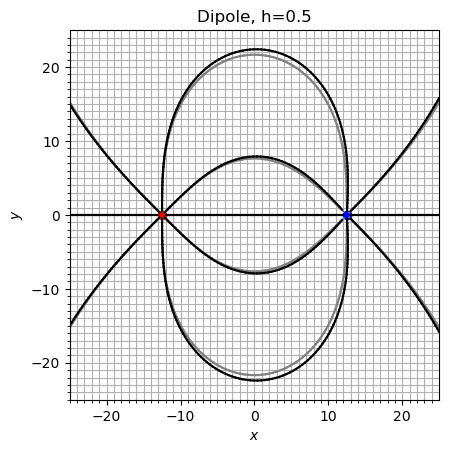

In [10]:
lim = 25 
dip_pos = np.array([[-lim/2, lim/2], [0, 0]])
dipole = np.array([Charge(dip_pos[0, 0], dip_pos[1, 0], 1), Charge(dip_pos[0, 1], dip_pos[1, 1], -1)]) 
ax = mplot(dipole, lim, lim)

eq = eq_points(8, 0.5, -12.5, 0)
h = 0.5

for point in eq:
    field_line(point, (dip_pos[0, 1], dip_pos[1, 1]), lim, dipole, 'rk2', 'gray', h, ax, True, 0.5)
    field_line(point, (dip_pos[0, 1], dip_pos[1, 1]), lim, dipole, 'euler', 'black', h, ax, True, 0.5)

ax.set_title("Dipole, h=0.5")

plt.show()


## B)

Plotting RK2 and Euler for a dipole and step size of 0.1:

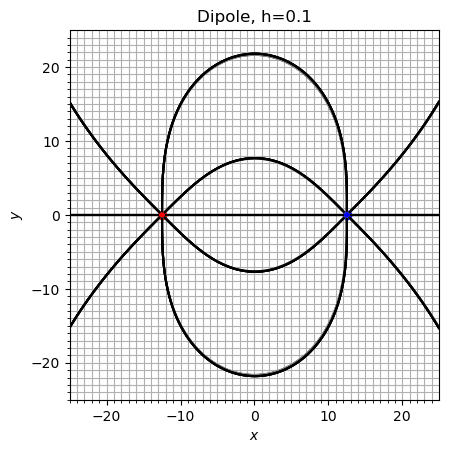

In [11]:
lim = 25
dip_pos = np.array([[-lim/2, lim/2], [0, 0]]) 
dipole = np.array([Charge(dip_pos[0, 0], dip_pos[1, 0], 1), Charge(dip_pos[0, 1], dip_pos[1, 1], -1)]) 
ax = mplot(dipole, lim, lim)

eq = eq_points(8, 0.5, -12.5, 0)

for point in eq:
    field_line(point, (dip_pos[0, 1], dip_pos[1, 1]), lim, dipole, 'rk2', 'gray', 0.1, ax, True, 0.5)
    field_line(point, (dip_pos[0, 1], dip_pos[1, 1]), lim, dipole, 'euler', 'black', 0.1, ax, True, 0.5)

ax.set_title("Dipole, h=0.1")

plt.show()


## C)

1. When h is bigger, there is a more noticeable difference between the RK2 and Euler methods. As h gets smaller, there is less of a difference between the two. This is as expected, the Euler method has an error of $\mathcal{O}(h)$ while the RK2 method has an error of $\mathcal{O}(h^2)$. At smaller h's the difference between the two is less significant.

2. The runtime of RK2 is significantly larger than that of the Euler method. RK2 takes about 1.8x as long (on average) as Euler does.

# 2)

## A)

Because dipole "toggle-ability" was introduced (above), there is no need to change code. Simply change charge configuration.

For a single positive charge at origin:

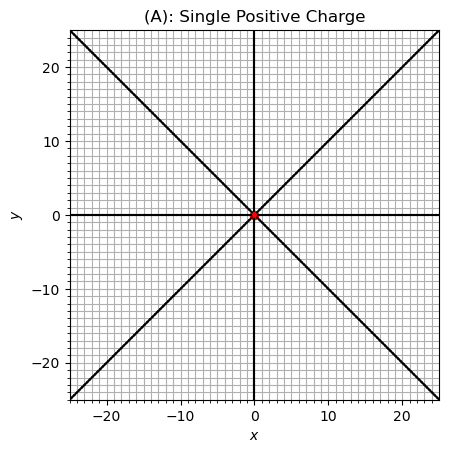

In [12]:
lim = 25
pos =np.array([Charge(0 , 0, 1)]) 
ax = mplot(pos, lim, lim)
h = 0.5
eq = eq_points(8, 0.5, pos[0].x, pos[0].y)

for point in eq: # Note that dipole parameter is set to False
        field_line(point, [0 , 0], lim, pos, 'rk2', 'black', h, ax, False, 0.5) 

ax.set_title("(A): Single Positive Charge")

plt.show()


Makes sense physically---field lines are radially outwards.

## B)

For two positive charges:
- Note that field lines starting directly horizontally towards the other positive charge (i.e. on the y = 0 line) create infinite loops; they have been hard-coded out

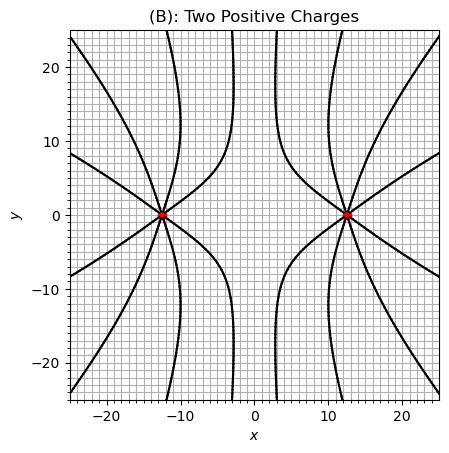

In [13]:
lim = 25
two_pos = np.array([Charge(12.5, 0, 1), Charge(-12.5, 0, 1)])

ax = mplot(two_pos, lim, lim)
h = 0.5
n = 10

eq1 = eq_points(n, 0.5, two_pos[0].x, two_pos[0].y)
eq2 = eq_points(n, 0.5, two_pos[1].x, two_pos[1].y)

for point1 in eq1:
        if abs(point1[1]-0) <= 0.01:
                continue
        field_line(point1, [0,0], lim, two_pos, 'euler', 'black', h, ax, False, 0.5)

for point2 in eq2:
        if abs(point2[1]-0)<= 0.01:
                continue
        field_line(point2, [0,0], lim, two_pos, 'euler', 'black', h, ax, False, 0.5)

ax.set_title("(B): Two Positive Charges")

plt.show()


Makes sense physically---there are no field lines pointing towards either of the charges from the other.

## C)

For two positive charges and one negative charge:

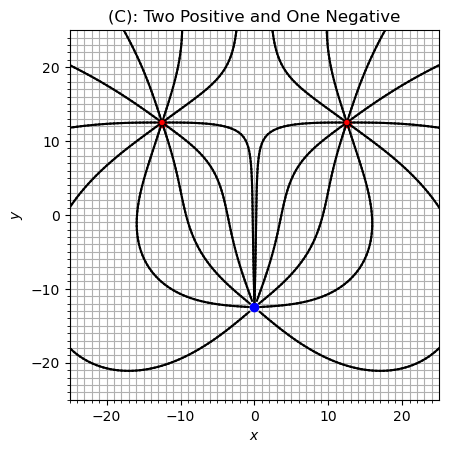

In [14]:
lim = 25
posneg = np.array([Charge(lim/2, lim/2, 1), Charge(-lim/2, lim/2, 1), Charge(0, -lim/2, -1)])

ax = mplot(posneg, lim, lim)
h = 0.5
n = 10

eq1 = eq_points(n, 0.5, posneg[0].x, posneg[0].y)
eq2 = eq_points(n, 0.5, posneg[1].x, posneg[1].y)

for point1 in eq1:
        field_line(point1, [posneg[2].x, posneg[2].y], lim, posneg, 'rk2', 'black', h, ax, False, 0.5)

for point2 in eq2:
        field_line(point2, [posneg[2].x, posneg[2].y], lim, posneg, 'rk2', 'black', h, ax, False, 0.5)

ax.set_title("(C): Two Positive and One Negative")

plt.show()


Makes sense physically---since there is a net-positive charge, some field lines go to infinity and don't end on a negative charge. 

# 3)

Need to re-define RK2 function to use the rotated electric field to calculate instead of the actual electric field. Call the modified function `rk22`

In [15]:
def rk22(xi, yi, Ex, Ey, charges, h):
    xmid, ymid = euler(xi, yi, Ex, Ey, h/2)
    Exmid, Eymid = net_efield(xmid, ymid, charges)    
    Exmidrot, Eymidrot = -Eymid, Exmid  # Rotate electric field

    xi, yi = euler(xi, yi, Exmidrot, Eymidrot, h) # Use rotated electric field to calculate final position

    
    return xi, yi

Plotting equipotentials:
- Note: termination criteria has been tweaked as to not break the loop immediately. If the new point is within the range and the current point is not, then terminate. If this is not changed and only the new point is used as the termination check, the loop breaks immediately as the first step is within the termination bound.

- Note: `np.clip` is used to make sure equipotential lines are inside the limits after they are teleported. If this is removed, the condition for symmetric teleportation is triggered on every loop, meaning the equipotential lines never reach back to where they start

In [16]:
def equipotential(start, charges, ax, h, lim, tol):
    current = start
    
    while True:
        Ex, Ey = net_efield(current[0], current[1], charges)
                
        new = rk22(current[0], current[1], Ex, Ey, charges, h)

        if not termination(current, start, lim, lim, tol, True) and termination(new, start, lim, lim, tol, True):
            break # New termination criteria: if the new point is within the range and the current point is not, then terminate

        if new[0] < -lim or new[0] > lim or new[1] < -lim or new[1] > lim: 
            new = (np.clip(new[0], -lim, lim), np.clip(-new[1], -lim, lim) )
            current = new # Use np.clip to make sure equipotential lines are inside the lims after teleportation
            continue # Don't plot when teleported


        ax.plot([current[0], new[0]], [current[1], new[1]], color="fuchsia", linestyle="-")
        
        current = new
    
    return ax


Plotting a single equipotential around the negative charge:

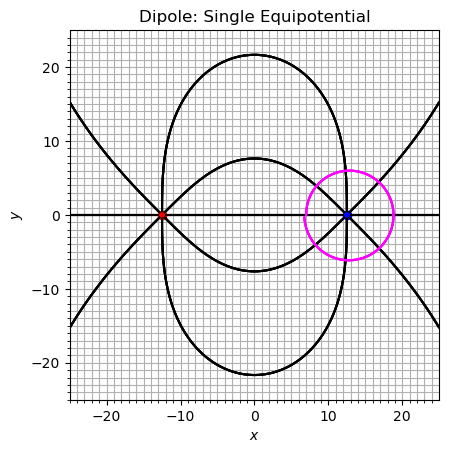

In [17]:
lim = 25 
dip_pos = np.array([[-lim/2, lim/2], [0, 0]]) 
dipole = np.array([Charge(dip_pos[0, 0], dip_pos[1, 0], 1), Charge(dip_pos[0, 1], dip_pos[1, 1], -1)]) 
ax = mplot(dipole, lim, lim)

eq = eq_points(8, 0.5, -12.5, 0)
h = 0.1

for point in eq:
    field_line(point, (dip_pos[0, 1], dip_pos[1, 1]), lim, dipole, 'rk2', 'black', h, ax, True, 0.5)

equipotential([7,0], dipole, ax, 0.1, lim, 0.35)
ax.set_title("Dipole: Single Equipotential")

plt.show()

# 4)

Function for calculating total potential for some array of x-values along y = 0:

In [18]:
def tot_potential(xgrid, charges):
    potentialslice = 0
    for charge in charges:
        potentialslice += charge.potential(xgrid, 0)
    return potentialslice

Note: levels were generated by looking at potslice output and creating an interval that more or less covers the significant potential ranges between the two charges.

In [19]:
xgrid = np.linspace(-12.5, 12.5, 1000, endpoint=False) # Don't include the endpoints (i.e. the charges) as potential -> infinity there
potslice = tot_potential(xgrid, dipole)
N = 7
levels = np.linspace(-0.24, 0.24, N) 
xvals = []

for level in levels:
    xvals.append(xgrid[np.argmin(potslice > level)]) # Append the last point where the potential is above the threshold

Plot 7 equipotential lines between the dipoles. 
- Note: this is generalized to N equipotential lines; only 7 were used as it provides a nice visual

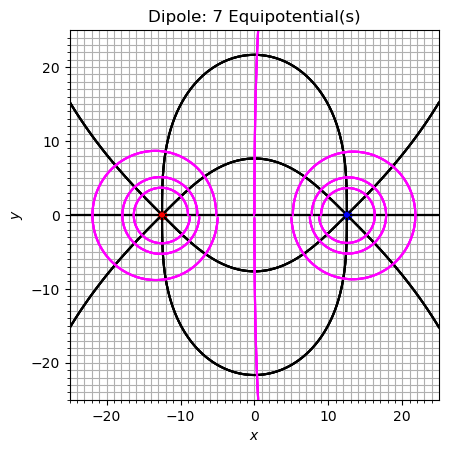

In [20]:
lim = 25 
dip_pos = np.array([[-lim/2, lim/2], [0, 0]]) 
dipole = np.array([Charge(dip_pos[0, 0], dip_pos[1, 0], 1), Charge(dip_pos[0, 1], dip_pos[1, 1], -1)]) 
ax = mplot(dipole, lim, lim)

eq = eq_points(8, 0.5, -12.5, 0)
h = 0.1

for point in eq:
    field_line(point, (dip_pos[0, 1], dip_pos[1, 1]), lim, dipole, 'rk2', 'black', h, ax, True, 0.5)

for val in xvals:
    equipotential([val, 0], dipole, ax, h, lim, 0.35)

ax.set_title(f'Dipole: {N} Equipotential(s)')

plt.show()